# Distance Heuristic V4 Training - Contrastive State-Node Learning

This notebook trains V4 which conditions on goal NODES rather than goal STATES.

## Key Improvements over V3
1. Policy conditions on goal nodes (not states) - avoids invalid state pairs
2. Dual encoder architecture: s_encoder (state→embedding) + g_encoder (node→embedding)
3. Simplified contrastive loss with normalized embeddings
4. No L2 regularization or dual formulation needed

## Goals
1. Collect training data (state-node pairs from planning graph)
2. Train distance heuristic using contrastive state-node learning
3. Evaluate learned distances vs true distances

In [1]:
%load_ext autoreload
%autoreload 2

## Setup

In [2]:
import sys
import numpy as np
import torch
from pathlib import Path

# Add src to path if needed
sys.path.insert(0, str(Path.cwd().parent / "src"))

from tamp_improv.benchmarks.gridworld_fixed import GridworldFixedTAMPSystem
from tamp_improv.approaches.improvisational.base import ImprovisationalTAMPApproach
from tamp_improv.approaches.improvisational.policies.multi_rl import MultiRLPolicy
from tamp_improv.approaches.improvisational.policies.rl import RLConfig
from tamp_improv.approaches.improvisational.collection import collect_total_shortcuts, collect_total_planning_graph
from tamp_improv.approaches.improvisational.distance_heuristic_v4 import (
    DistanceHeuristicV4,
    DistanceHeuristicV4Config,
)
from tamp_improv.approaches.improvisational.graph_training import compute_graph_distances

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu128
CUDA available: False
Using device: cpu


## Step 1: Create Gridworld Environment

In [3]:
# Create tiny gridworld
system = GridworldFixedTAMPSystem.create_default(
    num_cells=2,
    num_states_per_cell=5,
    num_teleporters=0,
    seed=42,
    max_episode_steps=200,
)

print(f"✓ Created GridworldTAMPSystem")
print(f"  System name: {system.name}")
print(f"  Action space: {system.env.action_space}")
print(f"  Observation space: {system.env.observation_space}")

✓ Created GridworldTAMPSystem
  System name: TAMPSystem
  Action space: Discrete(5)
  Observation space: Graph(Box(0.0, 10.0, (2,), float32), None)


## Step 2: Collect Training Data

This builds the planning graph and collects state pairs.

In [4]:
# Create approach for collection
rl_config = RLConfig(device=device)
policy = MultiRLPolicy(seed=42, config=rl_config)
approach = ImprovisationalTAMPApproach(system, policy, seed=42)
approach.training_mode = True

print("✓ Created approach")

✓ Created approach


In [5]:
# Collection config
config_dict = {
    "seed": 42,
    "collect_episodes": 100,
    "use_random_rollouts": True,
    "num_rollouts_per_node": 5,
    "max_steps_per_rollout": 100,
    "shortcut_success_threshold": 0.5,
}

# Collect data
print("\nCollecting training data...")
rng = np.random.default_rng(42)
training_data = collect_total_shortcuts(system, approach, config_dict, rng=rng)

print(f"\n✓ Collection complete!")
print(f"  Nodes with states: {len(training_data.node_states)}")
print(f"  Total shortcuts: {len(training_data.valid_shortcuts)}")
print(f"  Planning graph: {len(training_data.graph.nodes)} nodes, {len(training_data.graph.edges)} edges")



Building total planning graph from 100 episodes...

=== Episode 1/100 ===
Planning graph with 4 nodes and 4 edges
Starting BFS exploration from node 2: {(InCol0 robot0), (InRow0 robot0)}

[1] Exploring from node 2: frozenset({(InRow0 robot0), (InCol0 robot0)})
  Queue size: 0, Visited nodes: 1

BFS Exploration Complete
Visited 1/4 nodes
Discovered 1 unique atom sets
Total states collected: 1

Atom sets discovered:
  • (InCol0 robot0), (InRow0 robot0) (1 states)

Episode graph has 4 nodes, 4 edges
BFS collected states for 1 atom sets

=== Episode 2/100 ===
Planning graph with 4 nodes and 6 edges
Starting BFS exploration from node 3: {(InCol1 robot0), (InRow1 robot0)}

[1] Exploring from node 3: frozenset({(InCol1 robot0), (InRow1 robot0)})
  Queue size: 0, Visited nodes: 1

BFS Exploration Complete
Visited 1/4 nodes
Discovered 1 unique atom sets
Total states collected: 1

Atom sets discovered:
  • (InCol1 robot0), (InRow1 robot0) (1 states)

Episode graph has 4 nodes, 6 edges
BFS coll

## Step 3: Prepare State-Node Pairs and Atom-to-Node Mapping

V4 uses (state, node) pairs instead of (state, state) pairs.

In [6]:
# Extract planning graph
planning_graph = training_data.graph
all_node_states = training_data.node_states

# Create atoms_to_node mapping
atoms_to_node = {}
for node in planning_graph.nodes:
    atoms_to_node[node.atoms] = node.id

print(f"✓ Created atoms_to_node mapping with {len(atoms_to_node)} nodes")
print(f"\nNode mapping:")
for node in planning_graph.nodes:
    print(f"  Node {node.id}: {node.atoms}")

✓ Created atoms_to_node mapping with 4 nodes

Node mapping:
  Node 0: frozenset({(InCol1 robot0), (InRow0 robot0)})
  Node 1: frozenset({(InCol1 robot0), (InRow1 robot0)})
  Node 2: frozenset({(InRow0 robot0), (InCol0 robot0)})
  Node 3: frozenset({(InRow1 robot0), (InCol0 robot0)})


In [7]:
# Collect all (source_state, target_node) pairs
state_node_pairs = []
for source_node in planning_graph.nodes:
    for target_node in planning_graph.nodes:
        if source_node.id == target_node.id:
            continue
        
        if source_node.id not in all_node_states:
            continue
        
        source_states = all_node_states[source_node.id]
        
        if not source_states:
            continue
        
        # For each source state, pair it with the target node ID
        for source_state in source_states:
            state_node_pairs.append((source_state, target_node.id))

print(f"\n✓ Prepared {len(state_node_pairs)} state-node pairs for training")

# Sample a few pairs to inspect
print("\nSample state-node pairs:")
for i, (source_state, target_node) in enumerate(state_node_pairs[:3]):
    source_atoms = system.perceiver.step(source_state)
    target_atoms = planning_graph.nodes[target_node].atoms
    print(f"  Pair {i}: {len(source_atoms)} source atoms -> node {target_node} ({len(target_atoms)} atoms)")


✓ Prepared 207 state-node pairs for training

Sample state-node pairs:
  Pair 0: 2 source atoms -> node 1 (2 atoms)
  Pair 1: 2 source atoms -> node 1 (2 atoms)
  Pair 2: 2 source atoms -> node 1 (2 atoms)


## Step 4: Train Distance Heuristic V4

Train using contrastive state-node learning with normalized embeddings.

In [14]:
# Create distance heuristic config
heuristic_config = DistanceHeuristicV4Config(
    latent_dim=2,
    hidden_dims=[64, 64],
    learning_rate=1e-3,
    batch_size=128,
    buffer_size=10000,
    gamma=0.9,
    iters_per_epoch=1,
    device=device,
    repetition_factor=1,
    policy_temperature=1,
    learn_frequency=1
)

In [15]:
# Create and train heuristic
heuristic = DistanceHeuristicV4(config=heuristic_config, 
                                env=system.env,
                                perceiver=system.perceiver,
                                atoms_to_node=atoms_to_node,
                                node_to_states=training_data.node_states,
                                seed=42)

print("\nStarting training...\n")
heuristic.train(
    state_node_pairs=state_node_pairs,
    num_epochs=300,
    trajectories_per_epoch=10,
    max_episode_steps=100
)

print("\n✓ Training complete!")


Starting training...


Training distance heuristic V4 on 207 state-node pairs...
Device: cpu
Number of nodes: 4
State dimension: 2
Latent dimension: 2

Starting training for 300 epochs...
Using cosine annealing LR scheduler: 0.001 -> 1e-05

[Epoch 12/300]
  Buffer size: 130
  Learning rate: 0.000996
  Policy temperature: 0.9954
  --- Policy Performance ---
  Success rate: 70.00% (7/10)
  Avg trajectory length: 69.1
  Avg successful length: 55.4
  --- Training Metrics ---
  Total loss: 4.9019
  Alignment loss: 0.2525
  Uniformity loss: 4.6495
  Accuracy: 19.53%

[Epoch 13/300]
  Buffer size: 140
  Learning rate: 0.000995
  Policy temperature: 0.9946
  --- Policy Performance ---
  Success rate: 80.00% (8/10)
  Avg trajectory length: 64.6
  Avg successful length: 55.5
  --- Training Metrics ---
  Total loss: 4.8792
  Alignment loss: 0.1708
  Uniformity loss: 4.7084
  Accuracy: 38.28%

[Epoch 14/300]
  Buffer size: 150
  Learning rate: 0.000995
  Policy temperature: 0.9938
  --- Policy Pe

In [16]:
# Count node transitions in replay buffer
from collections import Counter
transitions = Counter()

for traj in heuristic.replay_buffer.trajectories:
    nodes = traj['nodes']
    for i in range(len(nodes) - 1):
        transitions[(nodes[i], nodes[i+1])] += 1

print("Node transitions:")
for (n0, n1), count in sorted(transitions.items()):
    print(f"  {n0} → {n1}: {count}")

Node transitions:
  0 → 0: 17338
  0 → 1: 680
  0 → 2: 781
  1 → 0: 772
  1 → 1: 15388
  1 → 3: 751
  2 → 0: 806
  2 → 2: 18953
  2 → 3: 823
  3 → 1: 821
  3 → 2: 818
  3 → 3: 17705


## Step 5: Inspect Trajectories

Check if the policy is successfully reaching goal nodes.

In [23]:
# Look at last trajectory
ind = 5
last_trajectory = heuristic.replay_buffer.trajectories[-ind]
last_metadata = heuristic.replay_buffer.trajectory_metadata[-ind]

print("Last trajectory:")
print(f"  States: {([x for x in last_trajectory['states']])}")
print(f"  Nodes: {last_trajectory['nodes']}")
print(f"\nMetadata:")
print(f"  Start state: {last_metadata['start_state']}")
print(f"  Goal node: {last_metadata['goal_node']}")
print(f"\nDid it reach goal? {last_trajectory['nodes'][-1] == last_metadata['goal_node']}")

Last trajectory:
  States: [array([0., 1.], dtype=float32), array([0., 2.], dtype=float32), array([0., 3.], dtype=float32), array([0., 4.], dtype=float32), array([0., 5.], dtype=float32)]
  Nodes: [2, 2, 2, 2, 3]

Metadata:
  Start state: [0. 1.]
  Goal node: 3

Did it reach goal? True


In [28]:
# Test rollout on a specific state-node pair
import numpy as np
from tamp_improv.benchmarks.gridworld import GraphInstance

# Reconstruct the start state from the metadata
# The metadata shows: [0. 0. 5. 0. 1. 0. 1. 7. 9. 1. 1. 1.]
# This appears to be the full GraphInstance.nodes flattened
# For gridworld with 2 objects, nodes shape is (2, 6)
start_node = 0
start_state = training_data.node_states[start_node][0]
start_state_flat = heuristic._flatten_state(start_state)
goal_node = 3

print("Testing rollout:")
print(f"  Start state (flattened): {start_state_flat}")
print(f"  Goal node: {goal_node}")

print(f"\nCreated start state: {start_state.nodes}")

states, nodes, success = heuristic.rollout(
    system.env,
    start_state,
    goal_node,
    max_steps=150,
)

print([x for x in states])
print(success)
print(len(states))

Testing rollout:
  Start state (flattened): [5. 0.]
  Goal node: 3

Created start state: [[5. 0.]]
[array([5., 0.], dtype=float32), array([4., 0.], dtype=float32), array([3., 0.], dtype=float32), array([2., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 1.], dtype=float32), array([1., 2.], dtype=float32), array([1., 3.], dtype=float32), array([1., 4.], dtype=float32), array([1., 5.], dtype=float32)]
True
10


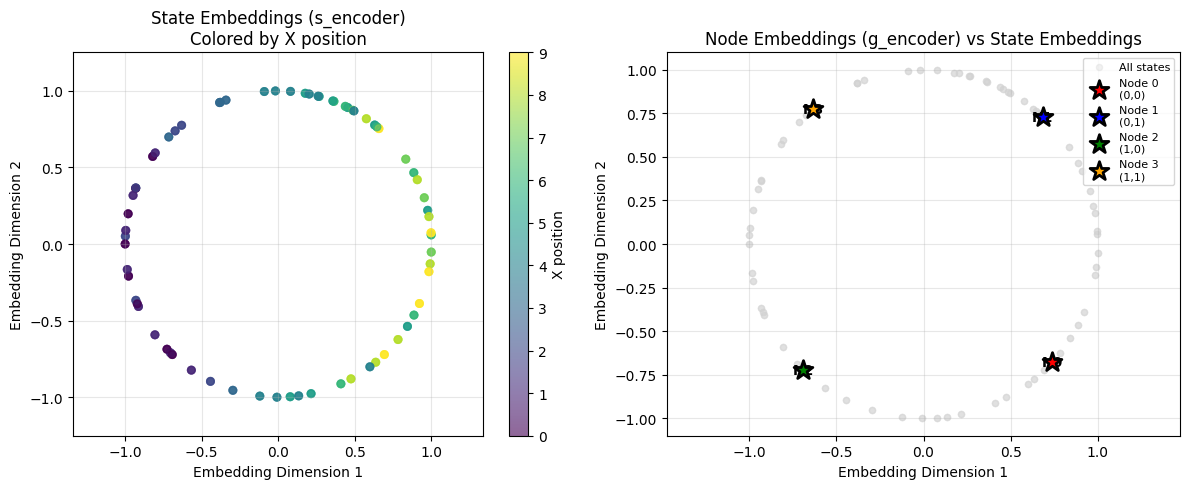


Closest states to each node:
  Node 0: Closest to state [9. 1.] (distance: 0.066)
  Node 1: Closest to state [9. 9.] (distance: 0.038)
  Node 2: Closest to state [0. 0.] (distance: 0.004)
  Node 3: Closest to state [2. 9.] (distance: 0.002)


In [29]:
# Visualize 2D embeddings for states and nodes
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Generate all possible gridworld positions
# For a 2-cell gridworld with 5 states per cell: 10x10 grid
grid_size = 10
state_positions = []
state_embeddings = []

# Encode all grid positions
for s, _ in state_node_pairs:   
    # Get normalized state embedding
    state = heuristic._flatten_state(s)
    state_positions.append(state)
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(heuristic.device)
        emb = heuristic.s_encoder(state_tensor).squeeze(0)
        emb_normalized = F.normalize(emb.unsqueeze(0), p=2, dim=1).squeeze(0)
        state_embeddings.append(emb_normalized.cpu().numpy())

state_embeddings = np.array(state_embeddings)

# Get normalized node embeddings
with torch.no_grad():
    node_embeddings_raw = heuristic.g_encoder.cpu()
    node_embeddings_normalized = F.normalize(node_embeddings_raw, p=2, dim=1).numpy()

# Create visualization
plt.figure(figsize=(12, 5))

# Left plot: State embeddings colored by position
plt.subplot(1, 2, 1)
scatter = plt.scatter(state_embeddings[:, 0], state_embeddings[:, 1], 
                     c=[x for x, y in state_positions], cmap='viridis', 
                     alpha=0.6, s=30)
plt.colorbar(scatter, label='X position')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('State Embeddings (s_encoder)\nColored by X position')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Right plot: Node embeddings + representative states
plt.subplot(1, 2, 2)

# Plot all state embeddings lightly in background
plt.scatter(state_embeddings[:, 0], state_embeddings[:, 1], 
           c='lightgray', alpha=0.3, s=20, label='All states')

# Plot node embeddings as large markers
node_labels = ['Node 0\n(0,0)', 'Node 1\n(0,1)', 'Node 2\n(1,0)', 
               'Node 3\n(1,1)', 'Node 4\n(1,1)+Goal']
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, (emb, label, color) in enumerate(zip(node_embeddings_normalized, node_labels, colors)):
    plt.scatter(emb[0], emb[1], s=200, marker='*', 
               color=color, edgecolors='black', linewidths=2,
               label=label, zorder=10)
    
    # Add text annotation
    plt.annotate(f'N{i}', (emb[0], emb[1]), 
                fontsize=10, fontweight='bold',
                ha='center', va='center')

plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Node Embeddings (g_encoder) vs State Embeddings')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Print which states are closest to each node
print("\nClosest states to each node:")
for node_id in range(len(node_embeddings_normalized)):
    node_emb = node_embeddings_normalized[node_id]
    
    # Compute distances from this node to all states
    distances = np.linalg.norm(state_embeddings - node_emb, axis=1)
    closest_idx = np.argmin(distances)
    closest_pos = state_positions[closest_idx]
    
    print(f"  Node {node_id}: Closest to state {closest_pos} (distance: {distances[closest_idx]:.3f})")


## Step 6: Evaluate Distance Heuristic

Compare learned distances with true distances.

In [30]:
from tamp_improv.approaches.improvisational.analyze import compute_true_distance
import random

print("\nEvaluating learned distances...")
results = []

sampled_pairs = [random.choice(state_node_pairs) for _ in range(100)]
for i, (source_state, target_node) in enumerate(sampled_pairs):
    # Get learned distance
    source_node = heuristic.get_node(source_state)
    if source_node == 4 or target_node == 4:
        continue
    learned_dist = heuristic.estimate_distance(source_state, target_node)
    
    # Get true distance (from rollouts)
    target_atoms = planning_graph.nodes[target_node].atoms
    true_dist = compute_true_distance(system, source_state, target_atoms)
    
    results.append({
        'source_idx': i,
        'source_node': source_node,
        'learned_distance': learned_dist,
        'true_distance': true_dist,
        'target_node': target_node,
    })
    
    if (i + 1) % 20 == 0:
        print(f"  Evaluated {i + 1}/{len(sampled_pairs)} pairs...")

print(f"\n✓ Evaluated {len(results)} state-node pairs")


Evaluating learned distances...
[GraphInstance(nodes=array([[1., 1.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[4., 4.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[1., 3.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[4., 3.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[0., 4.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[2., 3.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[3., 4.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[0., 0.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[4., 0.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[0., 3.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[1., 4.]], dtype=float32), edges=None, edge_links=None), GraphInstance(nodes=array([[1., 2.]], dtyp

NotImplementedError: True distance computation not implemented for GridworldFixedTAMPSystem

## Step 7: Analyze Results

In [71]:
# Filter finite results
finite_results = [r for r in results if r['true_distance'] != float('inf') and r['true_distance'] > 0]

print(f"\nResults Summary:")
print(f"  Total pairs: {len(results)}")
print(f"  Finite distance pairs: {len(finite_results)}")

if finite_results:
    true_dists = np.array([r['true_distance'] for r in finite_results])
    learned_dists = np.array([r['learned_distance'] for r in finite_results])
    
    # Statistics
    mae = np.mean(np.abs(true_dists - learned_dists))
    rmse = np.sqrt(np.mean((true_dists - learned_dists) ** 2))
    correlation = np.corrcoef(true_dists, learned_dists)[0, 1]
    
    print(f"\nStatistics:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  Correlation: {correlation:.3f}")
    
    print(f"\nDistance Ranges:")
    print(f"  True:    [{true_dists.min():.1f}, {true_dists.max():.1f}]")
    print(f"  Learned: [{learned_dists.min():.1f}, {learned_dists.max():.1f}]")


Results Summary:
  Total pairs: 69
  Finite distance pairs: 37

Statistics:
  MAE: 2.79
  RMSE: 3.69
  Correlation: 0.573

Distance Ranges:
  True:    [1.0, 10.0]
  Learned: [-0.5, 13.6]


In [72]:
# Show sample comparisons
if finite_results:
    print("\nSample Comparisons (sorted by true distance):")
    print(f"{'Idx':>4} | {'Source Node':>4} | {'Target Node':>4} | {'True':>6} | {'Learned':>8} | {'Error':>6}")
    print("-" * 45)
    
    # sorted_results = finite_results
    sorted_results = sorted(finite_results, key=lambda r: r['true_distance'])
    for r in sorted_results:  # Show first 20
        error = abs(r['true_distance'] - r['learned_distance'])
        print(
            f"{r['source_idx']:>4} | "
            f"{r['source_node']:>4} | "
            f"{r['target_node']:>4} | "
            f"{r['true_distance']:>6.1f} | "
            f"{r['learned_distance']:>8.1f} | "
            f"{error:>6.1f}"
        )


Sample Comparisons (sorted by true distance):
 Idx | Source Node | Target Node |   True |  Learned |  Error
---------------------------------------------
  52 |    1 |    2 |    1.0 |      3.0 |    2.0
  63 |    1 |    3 |    1.0 |     -0.5 |    1.5
  93 |    1 |    3 |    1.0 |     -0.5 |    1.5
   6 |    2 |    3 |    2.0 |      4.5 |    2.5
   9 |    2 |    1 |    2.0 |      7.0 |    5.0
  31 |    1 |    2 |    2.0 |      4.6 |    2.6
  34 |    2 |    1 |    2.0 |      7.0 |    5.0
  35 |    1 |    3 |    2.0 |      0.1 |    1.9
  48 |    2 |    1 |    2.0 |      7.0 |    5.0
  51 |    2 |    3 |    2.0 |      4.5 |    2.5
  96 |    2 |    3 |    2.0 |      4.5 |    2.5
  15 |    0 |    1 |    3.0 |      6.4 |    3.4
  18 |    1 |    3 |    3.0 |      3.2 |    0.2
  19 |    0 |    2 |    3.0 |      2.5 |    0.5
  30 |    1 |    3 |    3.0 |      3.2 |    0.2
  38 |    1 |    2 |    3.0 |      7.1 |    4.1
  39 |    0 |    2 |    3.0 |      2.5 |    0.5
  50 |    0 |    1 |    3.0 |

## Step 8: Visualize Results

In [ ]:
import matplotlib.pyplot as plt

if finite_results:
    true_dists = np.array([r['true_distance'] for r in finite_results])
    learned_dists = np.array([r['learned_distance'] for r in finite_results])
    
    plt.figure(figsize=(10, 5))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(true_dists, learned_dists, alpha=0.6)
    plt.plot([true_dists.min(), true_dists.max()], 
             [true_dists.min(), true_dists.max()], 
             'r--', label='Perfect correlation')
    plt.xlabel('True Distance')
    plt.ylabel('Learned Distance')
    plt.title(f'Learned vs True Distance\n(Correlation: {correlation:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error distribution
    plt.subplot(1, 2, 2)
    errors = true_dists - learned_dists
    plt.hist(errors, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Error (True - Learned)')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n(MAE: {mae:.2f}, RMSE: {rmse:.2f})')
    plt.axvline(0, color='r', linestyle='--', label='Zero error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize!")

## Step 9: Check Embedding Quality

Inspect if node embeddings are well-separated.

In [ ]:
# Get all node embeddings
with torch.no_grad():
    node_embeddings = heuristic.g_encoder.cpu().numpy()

print("Node embeddings:")
for i, emb in enumerate(node_embeddings):
    print(f"  Node {i}: {emb}")

# Compute pairwise distances
from scipy.spatial.distance import pdist, squareform
pairwise_dists = squareform(pdist(node_embeddings))

print("\nPairwise distances between node embeddings:")
print(pairwise_dists)

## Step 10: Save Heuristic (Optional)

In [ ]:
# Save trained heuristic
save_path = Path.cwd() / "outputs" / "distance_heuristic_v4"
save_path.mkdir(parents=True, exist_ok=True)

heuristic.save(str(save_path / "model"))
print(f"\n✓ Saved heuristic to {save_path}")